# Text classification of song lyrics

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import requests
from bs4 import BeautifulSoup
import re
import os
from collections import Counter
from wordcloud import WordCloud
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

## 1. Download a HTML page with links to songs

In [2]:
#r = requests.get('https://www.lyrics.com/artist/La-Dispute/807001')
#r

<Response [200]>

In [3]:
#s = requests.get('https://www.lyrics.com/artist/The-Weakerthans/371918')
#s

<Response [200]>

In [4]:
ld = r.text
tw = s.text

**1.1 Create Soup objects**

In [5]:
ld_soup = BeautifulSoup(ld, 'html.parser')
tw_soup = BeautifulSoup(tw, 'html.parser')

## 2. Extract hyperlinks of song pages

In [6]:
ld_song_rel_urls = []

for elem in ld_soup.find_all('a', href=re.compile('\/lyric\/[1|2]\d+')):
    ld_song_rel_urls.append(elem.get("href"))
ld_song_rel_urls

['/lyric/24436038/La+Dispute/A+Departure',
 '/lyric/24436037/La+Dispute/Harder+Harmonies',
 '/lyric/24436036/La+Dispute/St.+Paul+Missionary+Baptist+Church+Blues',
 '/lyric/24436035/La+Dispute/Edit+Your+Hometown',
 '/lyric/24436039/La+Dispute/A+Letter',
 '/lyric/24436034/La+Dispute/Safer+In+the+Forest-Love+Song+For+Poor+Michigan',
 '/lyric/24436033/La+Dispute/The+Most+Beautiful+Bitter+Fruit',
 '/lyric/24436032/La+Dispute/A+Poem',
 '/lyric/24436031/La+Dispute/King+Park',
 '/lyric/24436030/La+Dispute/Edward+Benz%2C+27+Times',
 '/lyric/24436029/La+Dispute/I+See+Everything',
 '/lyric/24436425/La+Dispute/A+Broken+Jar',
 '/lyric/24436027/La+Dispute/All+Our+Bruised+Bodies+and+the+Whole+Heart+Shrinks',
 '/lyric/24436026/La+Dispute/You+and+I+In+Unison',
 '/lyric/15049763/La+Dispute/Such+Small+Hands',
 '/lyric/15049764/La+Dispute/Said+the+King+to+the+River',
 '/lyric/15049765/La+Dispute/New+Storms+for+Older+Lovers',
 '/lyric/15049766/La+Dispute/Damaged+Goods',
 '/lyric/15049767/La+Dispute/Fall+Do

In [7]:
len(ld_song_rel_urls)

26

In [8]:
tw_song_rel_urls = []

for elem in tw_soup.find_all('a', href=re.compile('\/lyric\/30469[3|6]\d+')):
    tw_song_rel_urls.append(elem.get("href"))
tw_song_rel_urls

['/lyric/30469360/The+Weakerthans/Everything+Must+Go',
 '/lyric/30469359/The+Weakerthans/Aside',
 '/lyric/30469358/The+Weakerthans/Watermark',
 '/lyric/30469357/The+Weakerthans/Pamphleteer',
 '/lyric/30469356/The+Weakerthans/This+Is+a+Fire+Door+Never+Leave+Open',
 '/lyric/30469355/The+Weakerthans/Without+Mythologies',
 '/lyric/30469354/The+Weakerthans/Left+and+Leaving',
 '/lyric/30469353/The+Weakerthans/Elegy+for+Elsabet',
 '/lyric/30469352/The+Weakerthans/History+to+the+Defeated',
 '/lyric/30469351/The+Weakerthans/Exiles+Among+You',
 '/lyric/30469349/The+Weakerthans/Slips+and+Tangles',
 '/lyric/30469624/The+Weakerthans/Civil+Twilight',
 '/lyric/30469623/The+Weakerthans/Hymn+of+the+Medical+Oddity',
 '/lyric/30469622/The+Weakerthans/Relative+Surplus+Value',
 '/lyric/30469621/The+Weakerthans/Tournament+of+Hearts',
 '/lyric/30469619/The+Weakerthans/Elegy+From+Gump+Worsley',
 '/lyric/30469618/The+Weakerthans/Sun+in+an+Empty+Room',
 '/lyric/30469617/The+Weakerthans/Night+Windows',
 '/lyric/

In [9]:
len(tw_song_rel_urls)

23

## 3. Download and extract the song lyrics

**3.1 Write a function that downloads .txt files for each track**

In [10]:
def song_downloader(prefix, rel_urls): #function takes a file prefix and a list of relative urls
    song_full_urls = []
    counter = 0
    for url in rel_urls:
        song_full_urls.append("https://www.lyrics.com" + url)
        counter += 1
        for url in song_full_urls:
            with open(prefix + str(counter) + '.txt', 'w') as f:
                f.write(requests.get(url).text)
                f.close()

In [11]:
#song_downloader('ld_', ld_song_rel_urls)

In [12]:
#song_downloader('tw_', tw_song_rel_urls)

**3.2 Extract the lyrics from each file and add to a list**

In [14]:
tw_lyrics = []
for fn in os.listdir('../Files/The_weakerthans/'):
    text = open('../Files/The_weakerthans/' + fn, 'r')
    soup = BeautifulSoup(text, 'html.parser')
    if soup.body.find(id = 'lyric-body-text') == None:
        continue
    else:
        lyrics = soup.body.find(id = 'lyric-body-text').text
    lyrics = lyrics.replace('\n',' ')
    lyrics = lyrics.replace('\\', '')
    tw_lyrics.append(lyrics)    
tw_lyrics[:2]

['They\'re tearing up streets again, they\'re building a new hotel The mayor\'s out killing kids to keep taxes down And me and my anger sit folding a paper bird Letting the curtains turn to beating wings  Wish I had a socket-set to dismantle this morning And just one pair of clean socks and a photo of you  When you get off work tonight, meet me at the construction site And we\'ll write some notes to tape to the heavy machines Like "We hope they treat you well, hope you don\'t work too hard We hope you get to be happy sometimes"  Bring your Swiss-army knife and a bottle of something And I\'ll bring some spray paint and a new deck of cards  Hey, I found the safest place to keep all our tenderness To keep all those bad ideas, keep all our hope It\'s here in the smallest bones, the feet and the inner ear It\'s such an enormous thing to walk and to listen  And I\'d like to fall asleep to the beat of you breathing In a room near a truck stop on a highway somewhere  Well you are a radio, you 

In [16]:
ld_lyrics = []
for fn in os.listdir('../Files/La_dispute/'):
    text = open('../Files/La_dispute/' + fn, 'r')
    soup = BeautifulSoup(text, 'html.parser')
    if soup.body.find(id = 'lyric-body-text') == None:
        continue
    else:
        lyrics = soup.body.find(id = 'lyric-body-text').text
    lyrics = lyrics.replace('\n',' ')
    lyrics = lyrics.replace('\\', '')
    ld_lyrics.append(lyrics)    
ld_lyrics[:2]

['The Castle Builders : Now speak of anger, Forget all the fears you\'ve kept about love and sex and death and faith, Erased, or swinging sweet from around her neck and between her breasts. Let every lonely body finally break its fear of flesh and say, "How strange it must\'ve been back when we shook at the sight of sweat." Let our worries wander out of like water streaming from a spring, And sing of all the things our heads have failed to ruin yet. There\'s so much they have failed to ruin yet. Bright as lightning, loud as thunder, We\'ll move all the hurt aside to let love sustain our passions, And move up and onward. We are not our losses, we are only the extent to which we love. So build a home for your family, and build a castle for your friends. Now set their beds with sheets and blanketã, keep them safe until the end. I\'ve felt the damage and burn from the fallout. My love failed but theirs prevailed. My friends, I\'m only flesh and bone, But I won\'t let you die alone. So leav

In [18]:
#combine lyrics to one corpus
corpus = tw_lyrics + ld_lyrics
len(ld_lyrics), len(tw_lyrics), len(corpus)

(22, 19, 41)

## 4. Vectorize the text using the Bag Of Words method

In [19]:
labels = ['The Weakerthans'] * 19 + ['La Dispute'] * 22
#the labels are our y values

**4.1 Vectorize our corpus**

In [48]:
vec = CountVectorizer(stop_words='english', max_df=0.8)
X = vec.fit_transform(corpus)
X_df = pd.DataFrame(X.todense(), columns=vec.get_feature_names_out(), index=labels)
X_df.head()

,000,12,14,17,19,1963,1980,20,30,50,...,yards,year,years,yell,yellow,young,younger,youngest,youth,youthful
The Weakerthans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Weakerthans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Weakerthans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Weakerthans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Weakerthans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X.shape

(41, 2070)

**4.2 Transform and normalize with TF-IDF method**

In [62]:
tf = TfidfTransformer()
X_norm = tf.fit_transform(X)
X_norm_df = pd.DataFrame(X_norm.todense(), columns=vec.get_feature_names_out(), index=labels)
X_norm_df.head()

,000,12,14,17,19,1963,1980,20,30,50,...,yards,year,years,yell,yellow,young,younger,youngest,youth,youthful
The Weakerthans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Weakerthans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Weakerthans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Weakerthans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Weakerthans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
max_val = X_norm_df.max()
sorted_max = max_val.sort_values(ascending=False)
sorted_max.head()

sun        0.762552
tell       0.716172
right      0.712876
windows    0.664823
room       0.557023
dtype: float64

**4.3 Optional: Create pipeline**

This pipeline vectorises the lyrics using `CountVectorizer` and then transforms and normalises them with the TF-IDF method. As I want to look at the outcomes of the individual steps, we keep it commented out.

In [30]:
#vc_tfidf_pipe = Pipeline(steps=
#                        [('vectorizer', CountVectorizer(stop_words='english', max_df=0.8)),
#                         ('TF-IDF',TfidfTransformer())  
#                        ])

# We could also just use TfidfVectorizer() to get all steps at once

## 5. Train a classification model that predicts the artist from a piece of text

**5.1 Define X and y values and train/test split**

In [31]:
X = X_norm
y = labels

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=11)

**5.2 Logistic Regression**

In [33]:
m_logreg = LogisticRegression()
m_logreg.fit(X_train, y_train)
print(f'''Train score : {m_logreg.score(X_train, y_train)}
Test score : {m_logreg.score(X_test, y_test)}''')

Train score : 1.0
Test score : 1.0


In [34]:
cv_logreg = cross_validate(
    estimator=m_logreg,
    X=X_train,
    y=y_train,
    cv=5,            
    scoring="accuracy", 
    return_train_score=True)
cv_logreg

{'fit_time': array([0.01609921, 0.01233101, 0.01039505, 0.00738001, 0.00639701]),
 'score_time': array([0.00067091, 0.00055504, 0.00055313, 0.00036883, 0.00046897]),
 'test_score': array([0.85714286, 0.85714286, 0.83333333, 1.        , 1.        ]),
 'train_score': array([1., 1., 1., 1., 1.])}

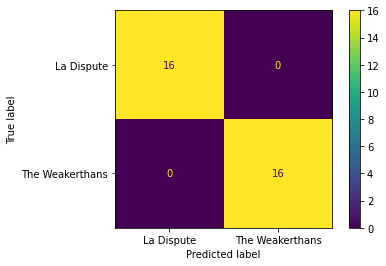

In [35]:
y_pred_train = m_logreg.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train);

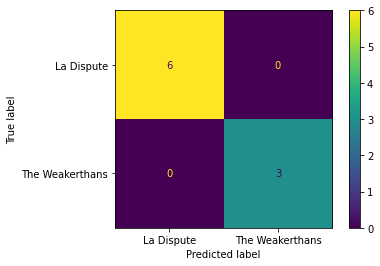

In [36]:
y_pred_test = m_logreg.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

**5.3 Random Forest**

In [37]:
m_rf = RandomForestClassifier(max_depth = 3, random_state=11)
m_rf.fit(X_train, y_train)
print(f'''Train score : {m_rf.score(X_train, y_train)}
Test score : {m_rf.score(X_test, y_test)}''')

Train score : 0.96875
Test score : 0.6666666666666666


In [38]:
cv_rf = cross_validate(
    estimator=m_rf, 
    X=X_train,        
    y=y_train,        
    cv=5,            
    scoring="accuracy",
    return_train_score=True)
cv_rf

{'fit_time': array([0.10355997, 0.06055498, 0.06187105, 0.06145406, 0.06229401]),
 'score_time': array([0.00470233, 0.00448608, 0.00500512, 0.00452924, 0.00469518]),
 'test_score': array([0.85714286, 1.        , 0.5       , 0.66666667, 0.83333333]),
 'train_score': array([0.96      , 1.        , 1.        , 1.        , 0.96153846])}

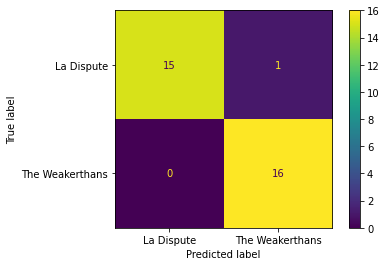

In [39]:
y_pred_train = m_rf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train);

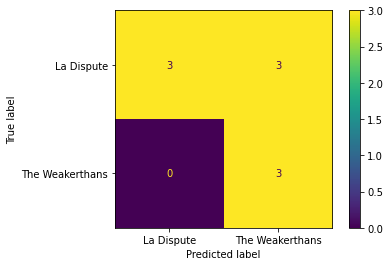

In [40]:
y_pred_test = m_rf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

**5.4 Naive Bayes**

In [41]:
m_nb = MultinomialNB()
m_nb.fit(X_train, y_train)
print(f'''Train score : {m_nb.score(X_train, y_train)}
Test score : {m_nb.score(X_test, y_test)}''')

Train score : 1.0
Test score : 0.8888888888888888


In [42]:
cv_nb = cross_validate(
    estimator=m_nb,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="accuracy",
    return_train_score=True)
cv_nb

{'fit_time': array([0.0066998 , 0.00089502, 0.00152493, 0.00082183, 0.00069094]),
 'score_time': array([0.0004499 , 0.00018811, 0.00144196, 0.00017619, 0.00018191]),
 'test_score': array([0.85714286, 0.57142857, 0.83333333, 0.83333333, 0.83333333]),
 'train_score': array([1., 1., 1., 1., 1.])}

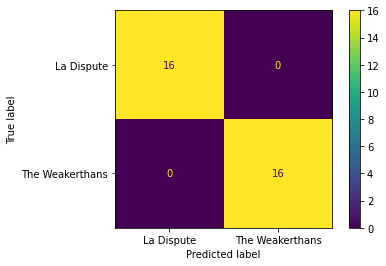

In [43]:
y_pred_train = m_nb.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train);

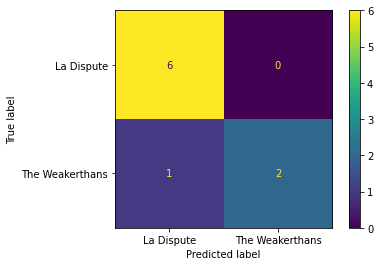

In [44]:
y_pred_test = m_nb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

After running three different models, the Logistic Regression performs the best on our current data set which is especially clear after cross validating the method. The values for the logistic regression are by far the closest to each other.

**5.5 Run a test with a couple of new lyrics**

In [72]:
test_lyrics = ["""You in the living room
You on a Tuesday afternoon
A breeze seen when the curtains move

You by the window with both feet up on the couch
Where you sit and you read and I watch you

From the office the sunlight frames your silhouette
I think of lighting fireworks, I think of pirouettes
I idly write down observations on the scene
Like do the blueprints name the rooms alone?
Do we name them on our own?
We hardly live in there

You with a book propped on your knees
A breeze seen in your coffee steam

I’m in the office thinking back to rules of poetry
It’s fourteen lines, the last two rhyme, what does pentameter mean?

You in the living room
Legs bent at forty-five degrees

I write AB AB, try to find your rhyme scheme
I look for objects on the desk with which to sculpt your image best
What would I name this could I paint it “Woman (reading)?” “Girl (at rest)?”

I remember it so well watching you shifting your weight, turning the page, I can see it all there
Inside a living room where only I live and never go in
A role in name alone

And I pause where I am for a second when I hear your name
Sometimes I think I see your face in improbable places
Do those moments replay for you?
When I’m suddenly there and then won’t go away
When you’re sitting in the living room reading for the afternoon
Do you put your book down look and try to find me there?

Sometimes I think of all the people who lived here before us
How the spaces in the memories you make change the room from just blueprints
To the place where you live

When you leave here
When you go from a home
You take all that you own but the memories echo

On hardwood floor in the living room
Tore the carpet the scratches below that we found
And the wine stain on the couch
We got drunk and decided we’d still try to move it around
And I can’t tell what the difference is between the ones that we made and the ones that we didn’t make
They all conjure images still
Where you sit and you read in the sunlight aware that I watch

And I live alone now
Save for the echoes

I live alone now
Save for the echoes""", 
"""Why don't you ever want to play?
I'm tired of this piece of string
You sleep as much as I do now
And you don't eat much of anything
I don't know who you're talking to
I made a search through every room
But all I found was dust that moved
In shadows of the afternoon

And listen, about those bitter songs you sing?
They're not helping anything
They won't make you strong

So, we should open up the house
Invite the tabby two doors down
You could ask your sister
If she doesn't bring her basset hound
Ask the things you shouldn't miss:
Tape-hiss and the Modern Man
The Cold War and card catalogues
To come and join us if they can

For girly drinks and parlor games
We'll pass around the easy lie
Of absolutely no regrets
And later maybe you could try
To let your losses dangle off
The sharp edge of a century
And talk about the weather, or
How the weather used to be

And I'll cater with all the birds that I can kill
Let their tiny feathers fill disappointment
Lie down; lick the sorrow from your skin
Scratch the terror and begin
To believe you're strong

All you ever want to do is drink and watch TV
And frankly that thing doesn't really interest me
I swear I'm going to bite you hard
And taste your tinny blood
If you don't stop the self-defeating lies
You've been repeating since the day you brought me home
I know you're strong""", """Funny what you think of after a collapse
While lying in the dirt the first thing that comes back is never quite what you’d have guessed
And if you could have, you probably would’ve said you’d check if all your limbs were intact still and then try to get out

We played house with the neighbors in their basement
Sister made me husband she was older so I did her bidding
I remember once their dad came in said, “You think this is bad?
You don’t know the half.” And he laughed.

It’s funny what things come back
The first things you see

How he sort of smiled like it’s only a joke but he was lying
There was something else inside of his eyes
All those secrets people tell to little children
Are warnings that they give them
Like, “Look, I’m unhappy. Please don’t make the same mistake as me.”

Why are those old worn out jokes on married life told at toasts at receptions still?
How does it never occur how often couples get burned and end uncertain in Splitsville?

Funny what you think of in the wreckage, lying there in the dirt and the dust and the glass
How you’re suddenly somewhere, in the desert, in the nighttime, and it’s getting close to Christmas
And then her and that movie voice she uses when she reads,
“Welcome to the Land of Enchantment” from a highway sign
And it’s late so you take the next exit

When that trip ended we came back the rent was due I was jobless
I guess in retrospect I should’ve sensed decay
Then that day, how you said, “I just don’t know” and I promised
We’d rearrange things to fix the mess I’d made here

But I guess in the end we just moved furniture around 3X

But I guess in the end it sort of feels like every day it’s harder to stay happy where you are
There are all these ways to look through the fence into your neighbor’s yard
Why even risk it? It’s safer to stay distant
When it’s so hard now to just be content
Because there’s always something else

Now I’m proposing my own toast, composing my own joke for those married men
Maybe I’m miserable, I’d rather run for mayor in Splitsville than suffer your jokes again"""]
# lyrics from La Dispute and Weakerthans songs.

In [73]:
test_vec = vec.transform(test_lyrics)
test_tf = tf.transform(test_vec)
m_logreg.predict(test_tf)

array(['The Weakerthans', 'The Weakerthans', 'La Dispute'], dtype='<U15')

It seems like our model is not as solid as the scores further up suggest. Your lyrics getting mistaken for John K. Samson (The Weakerthans) lyrics is a nice compliment, though. Is there any way we can improve it?

## 6. Wordcloud

**6.1 Define our WordCloud design**

In [50]:
x, y = np.ogrid[:300, :400]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(max_words=200,mask=mask, background_color='white', contour_color='steelblue')

**6.2 Write a function that calculates the frequencies of words**

In [51]:
def wordcount(strlst): #function takes a list of strings
    wc = {}
    for value, i in enumerate(strlst):
        count = wordcloud.process_text(strlst[value])
        wc = dict(Counter(wc) + Counter(count))
    return wc

In [52]:
count_tw = wordcount(tw_lyrics)

In [53]:
count_ld = wordcount(ld_lyrics)

**6.2 Create our wordclouds!**

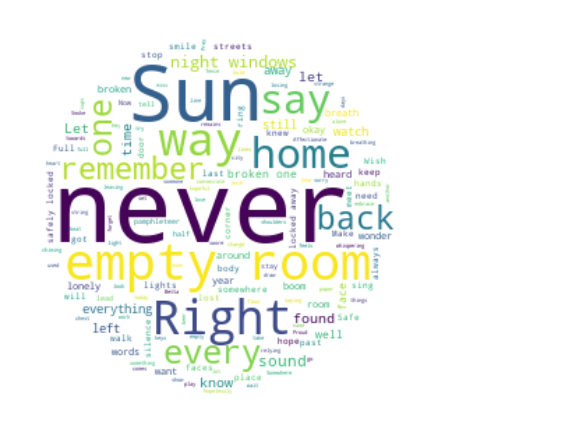

In [54]:
cloud_tw = wordcloud.generate_from_frequencies(count_tw)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(cloud_tw, interpolation='bilinear');

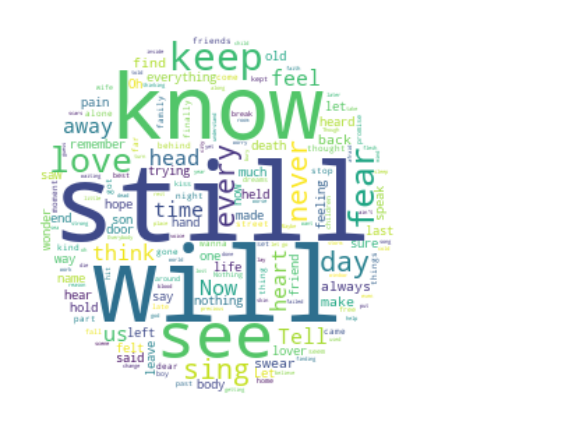

In [55]:
cloud_ld = wordcloud.generate_from_frequencies(count_ld)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(cloud_ld, interpolation='bilinear');